### Fitting OCCAM clusters.


We fit in the latent space whitout any whitening to keep things simple

### Setup

Importing all the required modules

### To-do

* Need to somehow account for missing values in input of spectra during training

* Need to remove outliers before generating the LatentVectorDataset (or be capable of fully deleting them). I don't want for my cluster_centered to be affected by outlier means

* In order to be sure thats its actually a real effect we need to check that were not just observing the effect of averaging latents.

In [ ]:
%load_ext autoreload
%autoreload 2

import astropy
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt

import inspect

from apoNN.src.occam import Occam

import apogee.tools.read as apread
import apogee.tools.path as apogee_path
from apogee.tools import bitmask
import collections


from apoNN.src.datasets import ApogeeDataset
from apoNN.src.utils import generate_loss_with_masking
from apoNN.src.utils import dump
from apoNN.src.utils import load
import apoNN.src.vectors as vector

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import torch.nn as nn
from sklearn.decomposition import PCA


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

apogee_path.change_dr(16)

## Loading datasets


We load all of our different datasets

In [ ]:
n_data=5000

In [3]:
autoencoder = torch.load("/share/splinter/ddm/taggingProject/apogeeFactory/outputs/guild/z10/ae_s_8000.p")


### Cleaning

we first create a temporary dataset where we attempt to 

In [4]:
occam = load("occam")
allStar_occam = occam["allStar"]
dataset_occam = ApogeeDataset(allStar_occam,outputs = ["aspcap","mask","physical","idx"])
occam_cluster_idxs = occam["cluster_idxs"]
z_occam = vector.OccamLatentVector(dataset_occam,autoencoder,occam_cluster_idxs,len(dataset_occam))

18.572296
13


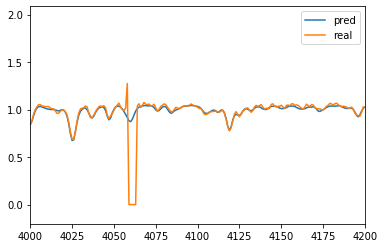

17.740644
20


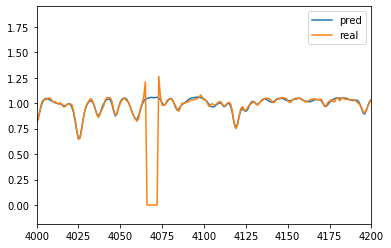

16.036333
22


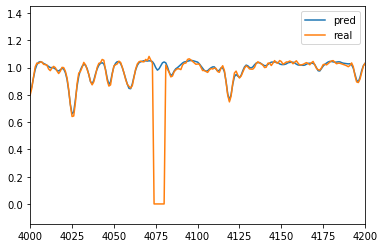

19.847042
23


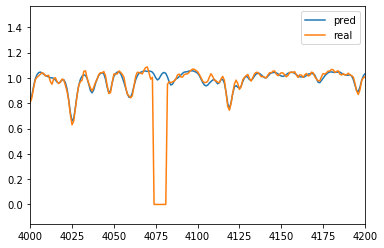

15.042608
32


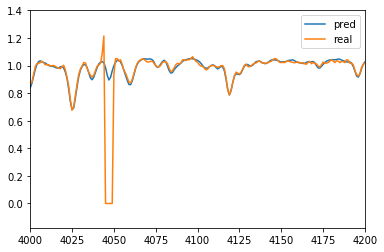

15.327846
47


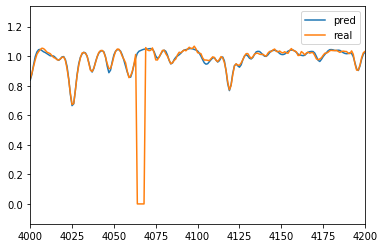

19.47109
75


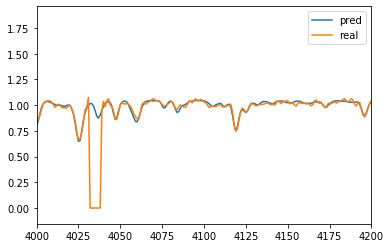

15.077244
76


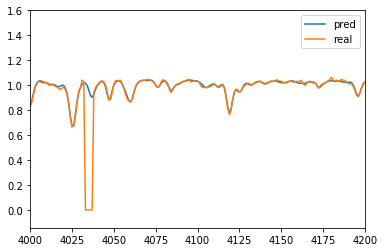

15.806814
84


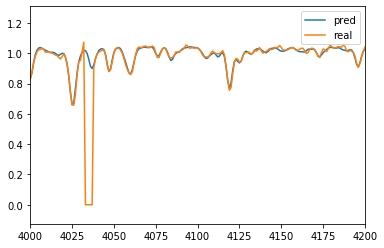

15.642108
92


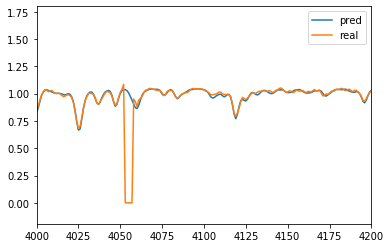

18.260803
135


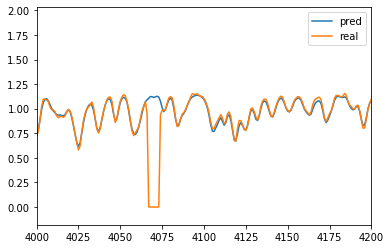

17.521067
138


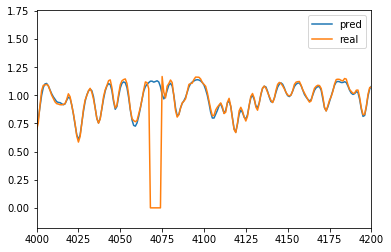

16.878635
141


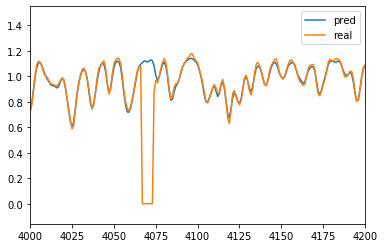

15.938319
142


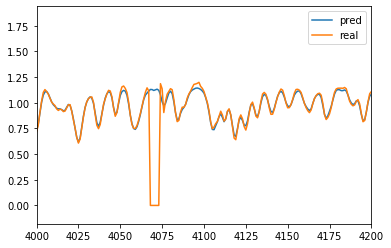

16.988016
145


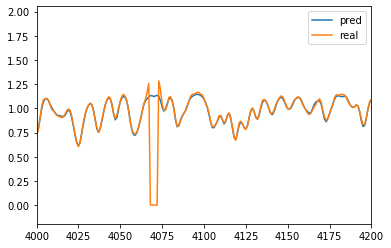

16.85689
150


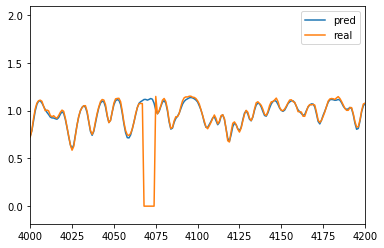

18.306093
152


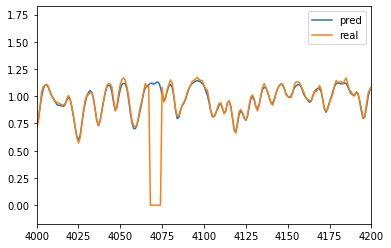

15.013573
153


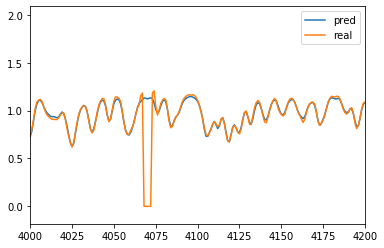

17.401648
154


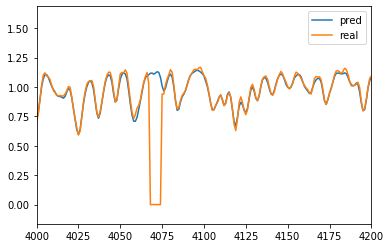

17.2513
156


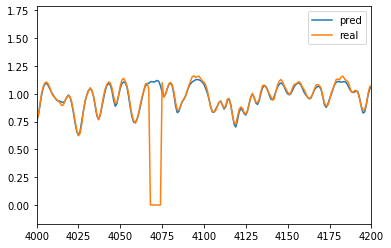

16.915308
160


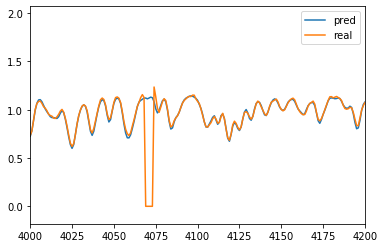

16.896866
161


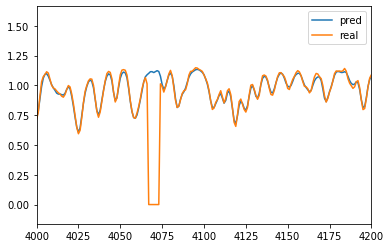

17.939926
162


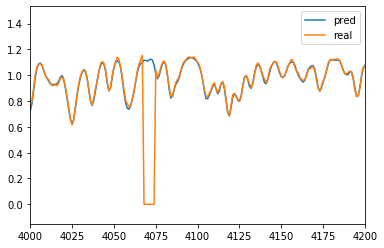

19.851242
163


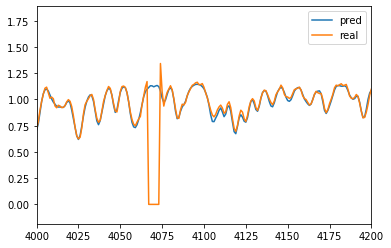

15.853338
169


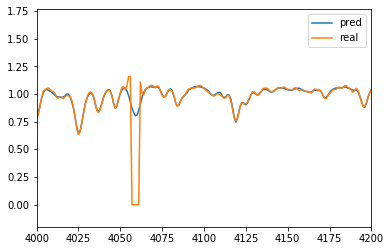

16.595314
197


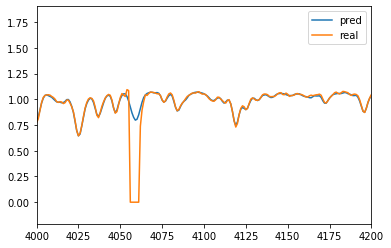

In [79]:
bad_indexes = []
for i in range(len(z_occam.raw)):
    err = np.sqrt(np.sum(((z_occam.get_x(i)-z_occam.get_x_pred(i))**2)))
    if err>15:
        print(err)
        print(i)
        bad_indexes.append(i)
        z_occam.plot(i)
        plt.show()


(4000, 4100)

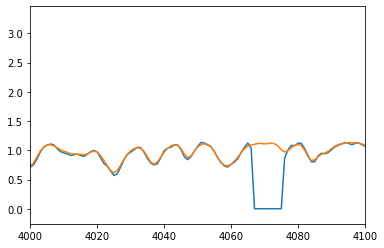

In [6]:
plt.plot(z_occam.get_x(145))
plt.plot(z_occam.get_x_pred(145))
plt.xlim(4000,4100)


In [7]:
len(bad_indexes)

6

In [8]:
occam = load("occam")
allStar_occam = occam["allStar"]
retained = np.delete(np.arange(len(allStar_occam)),bad_indexes)
#len(allStar_occam[retained])
dataset_occam = ApogeeDataset(allStar_occam[retained],outputs = ["aspcap","mask","physical","idx"])
occam_cluster_idxs = occam["cluster_idxs"][retained]
len(occam_cluster_idxs)

224

In [9]:
allStar_behaved_restricted =  load("allStar_behaved_restricted")
dataset_behaved_restricted =  ApogeeDataset(filename="behaved_restricted",outputs = ["aspcap","mask","physical","idx"])

In [10]:
considered_parameters = ["Teff","logg","Fe_H","O_FE","C_FE","Na_FE","Mg_FE","Si_FE","S_FE","Al_FE","P_FE","Ni_FE"] 
y = vector.Vector(np.array([allStar_behaved_restricted[param] for param in considered_parameters])[:,:n_data].T)

### Creating vectors from datasets

In [11]:
z = vector.LatentVector(dataset_behaved_restricted,autoencoder,n_data)

/share/splinter/ddm/taggingProject/apogeeFactory/apoNN/src/vectors.py:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  _,z = self.autoencoder(torch.tensor(self.dataset[idx][0]).to(device).unsqueeze(0))


In [12]:
z_occam = vector.OccamLatentVector(dataset_occam,autoencoder,occam_cluster_idxs,len(dataset_occam))

### Fitting the model

In [13]:
cluster_pca = PCA(n_components=10)

In [14]:
len(z_occam.cluster_centered)

224

In [15]:
cluster_pca.fit(np.delete(z_occam.cluster_centered,bad_indexes,axis=0))

PCA(copy=True, iterated_power='auto', n_components=10, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [16]:
cluster_pca.fit(z_occam.cluster_centered)

PCA(copy=True, iterated_power='auto', n_components=10, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [17]:
cluster_pca.fit(z.centered[1000:1200])

PCA(copy=True, iterated_power='auto', n_components=10, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [18]:
cluster_pca.explained_variance_

array([3.717811  , 1.6811796 , 0.82102454, 0.54490817, 0.36450544,
       0.24957256, 0.17848346, 0.07737574, 0.03894789, 0.01185861],
      dtype=float32)

In [19]:
cluster_pca.explained_variance_

array([3.717811  , 1.6811796 , 0.82102454, 0.54490817, 0.36450544,
       0.24957256, 0.17848346, 0.07737574, 0.03894789, 0.01185861],
      dtype=float32)

### Calculating projections along specific directions

In [20]:
w = vector.LinearTransformation(z,y)
nonlinear_w = vector.NonLinearTransformation(z,y)
nonlinear_w.fit(n_epochs=300)

err:0.15204334259033203
err:0.13469545543193817
err:0.12818285822868347
err:0.12362063676118851
err:0.10896509885787964
err:0.10399076342582703
err:0.08557599782943726
err:0.08248668164014816
err:0.07705040276050568
err:0.07908961176872253
err:0.06842111051082611
err:0.06573596596717834
err:0.06404592096805573
err:0.054298046976327896
err:0.08019144833087921
err:0.06122570112347603
err:0.04626614972949028
err:0.0452788807451725
err:0.03736327588558197
err:0.0427582748234272
err:0.04108746349811554
err:0.04183916375041008
err:0.03858385235071182
err:0.03584665432572365
err:0.03403116390109062
err:0.03283298388123512
err:0.03596489503979683
err:0.030030572786927223
err:0.033159174025058746
err:0.043301500380039215
err:0.04578692838549614
err:0.052722930908203125
err:0.04254651814699173
err:0.06862664967775345
err:0.04148994758725166
err:0.040054839104413986
err:0.03771974891424179
err:0.024014994502067566
err:0.033890414983034134
err:0.027081988751888275
err:0.0334896482527256
err:0.0374

err:0.02179177850484848
err:0.029240682721138
err:0.023448124527931213
err:0.021491780877113342
err:0.028896015137434006
err:0.03106139600276947
err:0.021686233580112457
err:0.020296597853302956
err:0.026128076016902924
err:0.027893168851733208
err:0.022029191255569458
err:0.025245925411581993
err:0.0223248153924942
err:0.02331957221031189
err:0.02179046906530857
err:0.02663632482290268
err:0.024830898270010948
err:0.02318078652024269
err:0.026226239278912544
err:0.020318957045674324
err:0.0295727476477623
err:0.0228007510304451
err:0.021575545892119408
err:0.01998824253678322
err:0.015390278771519661
err:0.02084900252521038
err:0.020367447286844254
err:0.020790236070752144
err:0.02356697805225849
err:0.019225524738430977
err:0.01910373941063881
err:0.018203845247626305
err:0.020351402461528778
err:0.016544731333851814
err:0.021997733041644096
err:0.02458137273788452
err:0.029932929202914238
err:0.03315309062600136
err:0.028580570593476295
err:0.042339127510786057
err:0.032004598528146

err:0.020534437149763107
err:0.02456648275256157
err:0.02451459690928459
err:0.0191385205835104
err:0.02010944113135338
err:0.027233760803937912
err:0.021613312885165215
err:0.019671492278575897
err:0.02699560858309269
err:0.029083749279379845
err:0.019477128982543945
err:0.018844788894057274
err:0.023961974307894707
err:0.02581961639225483
err:0.020723214372992516
err:0.023061035200953484
err:0.020698122680187225
err:0.021572917699813843
err:0.019904552027583122
err:0.02448078617453575
err:0.023453883826732635
err:0.02138361521065235
err:0.024704812094569206
err:0.01896468922495842
err:0.027115799486637115
err:0.021117299795150757
err:0.020521709695458412
err:0.01858970709145069
err:0.014382458291947842
err:0.019360095262527466
err:0.018998976796865463
err:0.019206063821911812
err:0.021798353642225266
err:0.017928702756762505
err:0.017824023962020874
err:0.01705540344119072
err:0.01869366317987442
err:0.015263363718986511
err:0.020761631429195404
err:0.023157421499490738
err:0.0282850

err:0.025284279137849808
err:0.015225951559841633
err:0.021565934643149376
err:0.018149742856621742
err:0.01922081597149372
err:0.023091353476047516
err:0.023251069709658623
err:0.01816719025373459
err:0.019069740548729897
err:0.026043960824608803
err:0.020618202164769173
err:0.01858682557940483
err:0.025763114914298058
err:0.027686823159456253
err:0.018117791041731834
err:0.01797322928905487
err:0.022806841880083084
err:0.024606212973594666
err:0.019799379631876945
err:0.021549873054027557
err:0.019625598564743996
err:0.020588839426636696
err:0.01861662045121193
err:0.022970154881477356
err:0.022374574095010757
err:0.020290028303861618
err:0.02379247173666954
err:0.01821836270391941
err:0.02547963708639145
err:0.01995752938091755
err:0.019812200218439102
err:0.01764007844030857
err:0.013818670064210892
err:0.01841951161623001
err:0.018068326637148857
err:0.018213897943496704
err:0.020646216347813606
err:0.017085662111639977
err:0.01698356494307518
err:0.016250725835561752
err:0.017702

err:0.024620629847049713
err:0.03295443207025528
err:0.02725454419851303
err:0.027195870876312256
err:0.024045268073678017
err:0.014678046107292175
err:0.020886007696390152
err:0.01765640266239643
err:0.018350867554545403
err:0.021914828568696976
err:0.022352419793605804
err:0.017457816749811172
err:0.01835191436111927
err:0.02518961764872074
err:0.019939247518777847
err:0.0179099440574646
err:0.024878351017832756
err:0.026555493474006653
err:0.01720104180276394
err:0.0173034630715847
err:0.022084614261984825
err:0.023795243352651596
err:0.019039863720536232
err:0.020431071519851685
err:0.018806446343660355
err:0.01991429179906845
err:0.017722193151712418
err:0.021815257146954536
err:0.021624870598316193
err:0.019567087292671204
err:0.023185404017567635
err:0.01764235459268093
err:0.024265794083476067
err:0.01899580843746662
err:0.01922381855547428
err:0.016916930675506592
err:0.013459166511893272
err:0.017874231562018394
err:0.01742689125239849
err:0.01744765415787697
err:0.0197839681

err:0.018544888123869896
err:0.0207317266613245
err:0.025140006095170975
err:0.02626849338412285
err:0.02399367466568947
err:0.031224073842167854
err:0.026230355724692345
err:0.02651095576584339
err:0.02304849959909916
err:0.014278464950621128
err:0.02042045257985592
err:0.01727653294801712
err:0.017753304913640022
err:0.021004581823945045
err:0.021697377786040306
err:0.017018930986523628
err:0.017848461866378784
err:0.024590961635112762
err:0.01942841336131096
err:0.017484670504927635
err:0.024174753576517105
err:0.025710223242640495
err:0.016567585989832878
err:0.0168295931071043
err:0.021471714600920677
err:0.02324950322508812
err:0.01843477040529251
err:0.0196079071611166
err:0.018161749467253685
err:0.019416222348809242
err:0.017095690593123436
err:0.020931702107191086
err:0.02108568698167801
err:0.019112151116132736
err:0.022729763761162758
err:0.01716749556362629
err:0.0233458261936903
err:0.018343230709433556
err:0.018787801265716553
err:0.016348954290151596
err:0.0132150016725

err:0.015961864963173866
err:0.014924483373761177
err:0.0162452794611454
err:0.013613943010568619
err:0.01806475594639778
err:0.020224735140800476
err:0.024501074105501175
err:0.025576302781701088
err:0.023503869771957397
err:0.029892267659306526
err:0.025287119671702385
err:0.0259354580193758
err:0.022266147658228874
err:0.013977394439280033
err:0.020037991926074028
err:0.016999676823616028
err:0.017300831153988838
err:0.02032199501991272
err:0.021171504631638527
err:0.016700876876711845
err:0.01747426949441433
err:0.02414700761437416
err:0.01911967433989048
err:0.017190365120768547
err:0.02357746846973896
err:0.025134548544883728
err:0.016151024028658867
err:0.016483033075928688
err:0.020914986729621887
err:0.02286224626004696
err:0.018001068383455276
err:0.018975384533405304
err:0.017704136669635773
err:0.019042711704969406
err:0.016598548740148544
err:0.020293865352869034
err:0.020670469850301743
err:0.018788360059261322
err:0.022389816120266914
err:0.016840379685163498
err:0.02264

err:0.01654927060008049
err:0.016251202672719955
err:0.01824786700308323
err:0.01539195142686367
err:0.01577133871614933
err:0.014694980345666409
err:0.01595475897192955
err:0.013467739336192608
err:0.0176643505692482
err:0.019846349954605103
err:0.024011407047510147
err:0.025034692138433456
err:0.023099085316061974
err:0.02880249358713627
err:0.0245230533182621
err:0.025477932766079903
err:0.02173944190144539
err:0.013780029490590096
err:0.019702306017279625
err:0.01676824502646923
err:0.01697646826505661
err:0.019823649898171425
err:0.020771818235516548
err:0.016467230394482613
err:0.017194921150803566
err:0.023811940103769302
err:0.018897270783782005
err:0.016964763402938843
err:0.023089328780770302
err:0.024685608223080635
err:0.01583540067076683
err:0.016200071200728416
err:0.020485764369368553
err:0.022522225975990295
err:0.01767878420650959
err:0.01848115399479866
err:0.017378410324454308
err:0.01875094324350357
err:0.016190070658922195
err:0.019822556525468826
err:0.02031131088

err:0.017895285040140152
err:0.015327037312090397
err:0.012763439677655697
err:0.016863463446497917
err:0.016358166933059692
err:0.01601053588092327
err:0.017873043194413185
err:0.015210205689072609
err:0.015604632906615734
err:0.01451682485640049
err:0.015747079625725746
err:0.013335105963051319
err:0.017328409478068352
err:0.019576674327254295
err:0.023570021614432335
err:0.024623559787869453
err:0.0227501317858696
err:0.027918949723243713
err:0.02391783893108368
err:0.02507835440337658
err:0.02139805257320404
err:0.013634881004691124
err:0.0194331593811512
err:0.01658444292843342
err:0.01671629399061203
err:0.01941811852157116
err:0.02045210264623165
err:0.016282228752970695
err:0.01699116826057434
err:0.02352726273238659
err:0.018714604899287224
err:0.016781724989414215
err:0.022715508937835693
err:0.02430885098874569
err:0.015610466711223125
err:0.0159659031778574
err:0.020135866478085518
err:0.022227702662348747
err:0.01741362176835537
err:0.018101776018738747
err:0.0171260274946

err:0.021659867838025093
err:0.016224171966314316
err:0.021105103194713593
err:0.01738707348704338
err:0.017612779513001442
err:0.015077964402735233
err:0.012639355845749378
err:0.016675155609846115
err:0.016198260709643364
err:0.015824012458324432
err:0.01753995008766651
err:0.015058409422636032
err:0.015445652417838573
err:0.014360739849507809
err:0.015568898990750313
err:0.013231834396719933
err:0.01707462966442108
err:0.0193680040538311
err:0.023201225325465202
err:0.024274855852127075
err:0.02246903069317341
err:0.02713332511484623
err:0.023421816527843475
err:0.02474942058324814
err:0.021180331707000732
err:0.01352827437222004
err:0.01921965554356575
err:0.01645543798804283
err:0.016488132998347282
err:0.01905904896557331
err:0.020198719576001167
err:0.016100531443953514
err:0.01682378351688385
err:0.02326374500989914
err:0.01854187808930874
err:0.01661445014178753
err:0.022401975467801094
err:0.023982102051377296
err:0.01540081575512886
err:0.015756255015730858
err:0.01982248015

err:0.015511870384216309
err:0.01900281012058258
err:0.01948920637369156
err:0.017752792686223984
err:0.02143176458775997
err:0.016066011041402817
err:0.020665371790528297
err:0.017237195745110512
err:0.017388658598065376
err:0.014854122884571552
err:0.012521833181381226
err:0.01650167442858219
err:0.016039162874221802
err:0.015652256086468697
err:0.01723770797252655
err:0.01493143942207098
err:0.015287688933312893
err:0.014217443764209747
err:0.015414086170494556
err:0.01313735730946064
err:0.01684606820344925
err:0.0191818717867136
err:0.022895948961377144
err:0.02396639809012413
err:0.022222019731998444
err:0.02639862522482872
err:0.023016011342406273
err:0.024451231583952904
err:0.021012011915445328
err:0.013456287793815136
err:0.01901824399828911
err:0.016336936503648758
err:0.016302572563290596
err:0.01874486729502678
err:0.019991222769021988
err:0.0159473679959774
err:0.016680829226970673
err:0.02306690253317356
err:0.018415048718452454
err:0.01648046262562275
err:0.022128000855

err:0.016873439773917198
err:0.01728164590895176
err:0.016719793900847435
err:0.01799224317073822
err:0.01533630769699812
err:0.018802277743816376
err:0.019257543608546257
err:0.01751449704170227
err:0.021251225844025612
err:0.015932250767946243
err:0.020268438383936882
err:0.017097363248467445
err:0.01717883162200451
err:0.014654258266091347
err:0.012416231445968151
err:0.016341371461749077
err:0.015893569216132164
err:0.015509732998907566
err:0.01696450635790825
err:0.014814750291407108
err:0.015143366530537605
err:0.014104433357715607
err:0.015280984342098236
err:0.01306137815117836
err:0.016652941703796387
err:0.019017212092876434
err:0.022619161754846573
err:0.023688023909926414
err:0.02200555056333542
err:0.025727158412337303
err:0.022673485800623894
err:0.024200495332479477
err:0.020870663225650787
err:0.013398053124547005
err:0.01884479820728302
err:0.0162284467369318
err:0.01611187681555748
err:0.018455123528838158
err:0.019810065627098083
err:0.01579798012971878
err:0.0165677

err:0.01497642695903778
err:0.015271094627678394
err:0.019187772646546364
err:0.021527230739593506
err:0.01670377515256405
err:0.017059767618775368
err:0.016604188829660416
err:0.017838751897215843
err:0.015175034292042255
err:0.018634729087352753
err:0.01904788613319397
err:0.017306454479694366
err:0.021106930449604988
err:0.015794403851032257
err:0.019929807633161545
err:0.01697351597249508
err:0.016992846503853798
err:0.014482329599559307
err:0.012325524352490902
err:0.016202544793486595
err:0.015764201059937477
err:0.015407591126859188
err:0.016716107726097107
err:0.014708493836224079
err:0.015030511654913425
err:0.014019826427102089
err:0.015163895674049854
err:0.012984976172447205
err:0.016482038423419
err:0.018867861479520798
err:0.022379424422979355
err:0.02342153899371624
err:0.02181137539446354
err:0.025148825719952583
err:0.022369544953107834
err:0.023968372493982315
err:0.020738447085022926
err:0.013348533771932125
err:0.018696270883083344
err:0.01612785831093788
err:0.0159

err:0.02257387526333332
err:0.018143702298402786
err:0.01616007462143898
err:0.02148180827498436
err:0.023025890812277794
err:0.014872955158352852
err:0.015123994089663029
err:0.019017329439520836
err:0.021408312022686005
err:0.01654249057173729
err:0.01687232032418251
err:0.016504187136888504
err:0.017707834020256996
err:0.0150314811617136
err:0.018470948562026024
err:0.018850773572921753
err:0.01710994727909565
err:0.02094559744000435
err:0.015675395727157593
err:0.0196222010999918
err:0.016843479126691818
err:0.016821973025798798
err:0.014335507526993752
err:0.012233869172632694
err:0.016066767275333405
err:0.015640119090676308
err:0.015316794626414776
err:0.01649138331413269
err:0.01461063139140606
err:0.014925720170140266
err:0.013949893414974213
err:0.0150455292314291
err:0.012928126379847527
err:0.016320472583174706
err:0.018737565726041794
err:0.022163236513733864
err:0.023161249235272408
err:0.0216330848634243
err:0.024624180048704147
err:0.022097524255514145
err:0.02375721186

err:0.017805516719818115
err:0.01938639022409916
err:0.015405750833451748
err:0.01627500355243683
err:0.022416522726416588
err:0.018048902973532677
err:0.016084464266896248
err:0.02129185013473034
err:0.022822847589850426
err:0.014774022623896599
err:0.014998954720795155
err:0.01884940266609192
err:0.021281996741890907
err:0.016391253098845482
err:0.01670699194073677
err:0.016402892768383026
err:0.017597639933228493
err:0.01490025408565998
err:0.018319474533200264
err:0.018673159182071686
err:0.016955388709902763
err:0.02080629952251911
err:0.015574587509036064
err:0.019311100244522095
err:0.016719043254852295
err:0.016673417761921883
err:0.014200204983353615
err:0.012154048308730125
err:0.015932871028780937
err:0.015519809909164906
err:0.015228839591145515
err:0.01628594473004341
err:0.01451305765658617
err:0.014824018813669682
err:0.013893810100853443
err:0.014949674718081951
err:0.012875259853899479
err:0.016178550198674202
err:0.018604854121804237
err:0.02197871543467045
err:0.0229

err:0.013255697675049305
err:0.01832270249724388
err:0.01590246893465519
err:0.015568539500236511
err:0.017647460103034973
err:0.0192729402333498
err:0.015306694433093071
err:0.016197754070162773
err:0.022268500179052353
err:0.017965365201234818
err:0.016009511426091194
err:0.02111528441309929
err:0.02265363186597824
err:0.01467935461550951
err:0.014900402165949345
err:0.018707431852817535
err:0.02118959091603756
err:0.016257524490356445
err:0.01656660996377468
err:0.01629585027694702
err:0.017504701390862465
err:0.014780626632273197
err:0.01819474622607231
err:0.018512926995754242
err:0.016805754974484444
err:0.020668884739279747
err:0.015489893034100533
err:0.019036225974559784
err:0.016612906008958817
err:0.016543375328183174
err:0.014086428098380566
err:0.012079024687409401
err:0.015818705782294273
err:0.015422157011926174
err:0.01516510359942913
err:0.01608925499022007
err:0.014432745054364204
err:0.014743869192898273
err:0.013844329863786697
err:0.014866940677165985
err:0.0128342

err:0.02338983491063118
err:0.02146528847515583
err:0.02325458824634552
err:0.020373309031128883
err:0.013209228403866291
err:0.018208395689725876
err:0.015851961448788643
err:0.015440951101481915
err:0.01750154234468937
err:0.019171975553035736
err:0.015214497223496437
err:0.016123605892062187
err:0.02212388440966606
err:0.017895296216011047
err:0.01592942513525486
err:0.02095855213701725
err:0.02249121479690075
err:0.014588398858904839
err:0.014794988557696342
err:0.01858021691441536
err:0.021120822057127953
err:0.016138216480612755
err:0.016430048272013664
err:0.016200870275497437
err:0.017419297248125076
err:0.014687281101942062
err:0.018070554360747337
err:0.018371427431702614
err:0.016660528257489204
err:0.020540352910757065
err:0.015403506346046925
err:0.01879202388226986
err:0.016500324010849
err:0.016420481726527214
err:0.013978379778563976
err:0.012014656327664852
err:0.015694886445999146
err:0.015322154387831688
err:0.015110195614397526
err:0.015915919095277786
err:0.0143565

err:0.018220454454421997
err:0.021535638719797134
err:0.022278403863310814
err:0.02102651260793209
err:0.02304026111960411
err:0.02128671668469906
err:0.02307995595037937
err:0.020286856219172478
err:0.013169581070542336
err:0.018110381439328194
err:0.015800505876541138
err:0.015316938050091267
err:0.017368173226714134
err:0.0190749391913414
err:0.015128557570278645
err:0.016065429896116257
err:0.02198408916592598
err:0.01782885566353798
err:0.015846792608499527
err:0.020808393135666847
err:0.02233540639281273
err:0.014513683505356312
err:0.01470320113003254
err:0.018468618392944336
err:0.021056480705738068
err:0.01603156328201294
err:0.01631085015833378
err:0.01610913686454296
err:0.017344729974865913
err:0.014599804766476154
err:0.017962414771318436
err:0.018245313316583633
err:0.016523757949471474
err:0.02042345702648163
err:0.015331522561609745
err:0.018570398911833763
err:0.016398170962929726
err:0.01630728878080845
err:0.013879094272851944
err:0.011961975134909153
err:0.015600968

err:0.013694178313016891
err:0.014702151529490948
err:0.012716877274215221
err:0.015747463330626488
err:0.018103456124663353
err:0.021404674276709557
err:0.02209407463669777
err:0.020889151841402054
err:0.02272515371441841
err:0.02113141492009163
err:0.022923890501260757
err:0.020198415964841843
err:0.013150013983249664
err:0.018005171790719032
err:0.015748905017971992
err:0.015207669697701931
err:0.017245054244995117
err:0.018980372697114944
err:0.015056299045681953
err:0.015999997034668922
err:0.02183154784142971
err:0.01775679551064968
err:0.0157689917832613
err:0.020663153380155563
err:0.022194789722561836
err:0.014435358345508575
err:0.014613652601838112
err:0.018372971564531326
err:0.02098471112549305
err:0.015930118039250374
err:0.016199741512537003
err:0.01602409966289997
err:0.017265593633055687
err:0.014511515386402607
err:0.01785469800233841
err:0.01812751404941082
err:0.0163924228399992
err:0.020298833027482033
err:0.015258501283824444
err:0.018366683274507523
err:0.0163070

err:0.014988147653639317
err:0.015519145876169205
err:0.014174114912748337
err:0.014522610232234001
err:0.013635273091495037
err:0.014641111716628075
err:0.012677397578954697
err:0.015658048912882805
err:0.017992744222283363
err:0.02128235623240471
err:0.021927369758486748
err:0.020746976137161255
err:0.02243359573185444
err:0.02097422257065773
err:0.022789185866713524
err:0.02012447640299797
err:0.013134369626641273
err:0.017908625304698944
err:0.01569974794983864
err:0.015101096592843533
err:0.017137810587882996
err:0.018887478858232498
err:0.014995747245848179
err:0.01592571660876274
err:0.02169192023575306
err:0.017681660130620003
err:0.015687497332692146
err:0.020528534427285194
err:0.02205466292798519
err:0.014366106130182743
err:0.014543755911290646
err:0.018284346908330917
err:0.020912569016218185
err:0.015844520181417465
err:0.0160951167345047
err:0.01593874953687191
err:0.01719893142580986
err:0.014440149068832397
err:0.0177682526409626
err:0.018018435686826706
err:0.01628405

err:0.013615195639431477
err:0.011847146786749363
err:0.015350393019616604
err:0.014990727417171001
err:0.014947967603802681
err:0.015397380106151104
err:0.014123249799013138
err:0.014472858048975468
err:0.013571212068200111
err:0.014596101827919483
err:0.012645289301872253
err:0.015576191246509552
err:0.01788456365466118
err:0.02116607315838337
err:0.02174552157521248
err:0.020610718056559563
err:0.022174054756760597
err:0.02082154154777527
err:0.022661663591861725
err:0.020065736025571823
err:0.013116016983985901
err:0.017811603844165802
err:0.015645958483219147
err:0.014990387484431267
err:0.01703280210494995
err:0.018797369673848152
err:0.014928868971765041
err:0.015849018469452858
err:0.021562756970524788
err:0.017606409266591072
err:0.015601650811731815
err:0.020397428423166275
err:0.021927671507000923
err:0.014301861636340618
err:0.01448577269911766
err:0.01820075698196888
err:0.020853182300925255
err:0.015765687450766563
err:0.01598677970468998
err:0.01585773006081581
err:0.017

err:0.015072232112288475
err:0.017862899228930473
err:0.01607893966138363
err:0.015930522233247757
err:0.013539443723857403
err:0.01180537324398756
err:0.015265855006873608
err:0.014918560162186623
err:0.014902970753610134
err:0.015289663337171078
err:0.01407529879361391
err:0.014429699629545212
err:0.013508845120668411
err:0.014549637213349342
err:0.012605714611709118
err:0.015495412051677704
err:0.017769314348697662
err:0.021063759922981262
err:0.021585311740636826
err:0.02049090526998043
err:0.02194758877158165
err:0.020696168765425682
err:0.022528061643242836
err:0.019996564835309982
err:0.013087786734104156
err:0.01772676594555378
err:0.015599182806909084
err:0.014891160652041435
err:0.016944846138358116
err:0.018713833764195442
err:0.014874322339892387
err:0.01578240469098091
err:0.021437998861074448
err:0.017536483705043793
err:0.01552784163504839
err:0.02027878910303116
err:0.0217940304428339
err:0.014242446050047874
err:0.014425077475607395
err:0.01811414211988449
err:0.020798

err:0.014258022420108318
err:0.017560908570885658
err:0.01770462468266487
err:0.01600709743797779
err:0.019914470613002777
err:0.015011012554168701
err:0.017717726528644562
err:0.01599987968802452
err:0.015836143866181374
err:0.013467162847518921
err:0.011768306605517864
err:0.015182635746896267
err:0.014850443229079247
err:0.014865926466882229
err:0.015184640884399414
err:0.014022302813827991
err:0.014396769925951958
err:0.013445784337818623
err:0.014508728869259357
err:0.012577713467180729
err:0.015421466901898384
err:0.017669357359409332
err:0.020956194028258324
err:0.02143060229718685
err:0.020367782562971115
err:0.021721437573432922
err:0.020572427660226822
err:0.02240152843296528
err:0.019933030009269714
err:0.01305565144866705
err:0.017640041187405586
err:0.01554842945188284
err:0.014796906150877476
err:0.016860119998455048
err:0.01863487996160984
err:0.014818932861089706
err:0.01571611315011978
err:0.02131849341094494
err:0.017473509535193443
err:0.015473687089979649
err:0.0201

err:0.015554234385490417
err:0.015719475224614143
err:0.01562341395765543
err:0.016969235613942146
err:0.014198689721524715
err:0.0174978319555521
err:0.017609739676117897
err:0.015921281650662422
err:0.01983816921710968
err:0.01495272945612669
err:0.01758505590260029
err:0.015924645587801933
err:0.015750709921121597
err:0.013405175879597664
err:0.011737963184714317
err:0.015108471736311913
err:0.014779860153794289
err:0.014833035878837109
err:0.015094328671693802
err:0.01397441141307354
err:0.014369383454322815
err:0.01339106634259224
err:0.014465700834989548
err:0.012542599812150002
err:0.01534357387572527
err:0.01757206954061985
err:0.020852044224739075
err:0.021272767335176468
err:0.020251402631402016
err:0.02151874639093876
err:0.020448504015803337
err:0.022275766357779503
err:0.0198699701577425
err:0.013022472150623798
err:0.01756490021944046
err:0.01548505388200283
err:0.014698736369609833
err:0.016777249053120613
err:0.018563900142908096
err:0.01476153451949358
err:0.0156536083

err:0.014107017777860165
err:0.014235529117286205
err:0.01789483241736889
err:0.020639894530177116
err:0.015494183637201786
err:0.015645800158381462
err:0.015548218041658401
err:0.01692764088511467
err:0.014146462082862854
err:0.01743282936513424
err:0.01751251518726349
err:0.01583668775856495
err:0.01976167969405651
err:0.014902215451002121
err:0.017451424151659012
err:0.0158500075340271
err:0.015663117170333862
err:0.013347549363970757
err:0.011712186969816685
err:0.015025819651782513
err:0.014710423536598682
err:0.014791330322623253
err:0.015006523579359055
err:0.01392494235187769
err:0.014336965046823025
err:0.01333694625645876
err:0.014428261667490005
err:0.012515629641711712
err:0.015280167572200298
err:0.01747800223529339
err:0.020755311474204063
err:0.0211208276450634
err:0.02014014683663845
err:0.021328555420041084
err:0.020325548946857452
err:0.0221477672457695
err:0.01981668919324875
err:0.012987779453396797
err:0.017500828951597214
err:0.015430789440870285
err:0.01460604090

err:0.01728370226919651
err:0.015312991105020046
err:0.01984812691807747
err:0.021388789638876915
err:0.014068648219108582
err:0.01417667418718338
err:0.01782863959670067
err:0.020589567720890045
err:0.01543570589274168
err:0.015584024600684643
err:0.015472940169274807
err:0.016878873109817505
err:0.014095785096287727
err:0.01736466772854328
err:0.017422746866941452
err:0.015762630850076675
err:0.019696010276675224
err:0.014850406907498837
err:0.017322417348623276
err:0.015781782567501068
err:0.015580561943352222
err:0.013293508440256119
err:0.011689304374158382
err:0.014957692474126816
err:0.014643432572484016
err:0.014760755002498627
err:0.014923468232154846
err:0.013879476115107536
err:0.014301834627985954
err:0.013281752355396748
err:0.014397308230400085
err:0.012486488558351994
err:0.015222056768834591
err:0.01738477684557438
err:0.020663905888795853
err:0.02098204381763935
err:0.02001674473285675
err:0.021138297393918037
err:0.02021821402013302
err:0.02202722616493702
err:0.01975

err:0.017308512702584267
err:0.020586445927619934
err:0.02086447738111019
err:0.019923439249396324
err:0.020989375188946724
err:0.02013085037469864
err:0.02191508188843727
err:0.01970618963241577
err:0.012936943210661411
err:0.017373962327837944
err:0.015340975485742092
err:0.014433203265070915
err:0.01656481809914112
err:0.01839672401547432
err:0.014606088399887085
err:0.015523440204560757
err:0.020850999280810356
err:0.017224090173840523
err:0.015258255414664745
err:0.019735103473067284
err:0.021293876692652702
err:0.014023584313690662
err:0.014122426509857178
err:0.017767181620001793
err:0.02053871750831604
err:0.01537039503455162
err:0.015522229485213757
err:0.015406164340674877
err:0.016827471554279327
err:0.014046643860638142
err:0.017293959856033325
err:0.01733982563018799
err:0.015689386054873466
err:0.019630607217550278
err:0.014804115518927574
err:0.017212389037013054
err:0.01572083868086338
err:0.01549900695681572
err:0.01323496550321579
err:0.011662417091429234
err:0.014894

err:0.013986519537866116
err:0.014069844968616962
err:0.017728189006447792
err:0.020504361018538475
err:0.015320214442908764
err:0.01547221839427948
err:0.015353535301983356
err:0.016786301508545876
err:0.013993616215884686
err:0.017232444137334824
err:0.017267679795622826
err:0.01563001051545143
err:0.01956862583756447
err:0.01476005557924509
err:0.017116522416472435
err:0.01566644385457039
err:0.015430326573550701
err:0.013181864283978939
err:0.011644363403320312
err:0.014837754890322685
err:0.014522657729685307
err:0.014696147292852402
err:0.014776015654206276
err:0.013786518014967442
err:0.014230315573513508
err:0.01319770235568285
err:0.014360535889863968
err:0.012445740401744843
err:0.015116425231099129
err:0.01722077466547489
err:0.020495422184467316
err:0.02073218859732151
err:0.01982240565121174
err:0.020838581025600433
err:0.020046966150403023
err:0.021777423098683357
err:0.01965043693780899
err:0.012909065932035446
err:0.01730223000049591
err:0.015292985364794731
err:0.01434

err:0.014515098184347153
err:0.015440121293067932
err:0.02065182663500309
err:0.017111515626311302
err:0.015164957381784916
err:0.01955357939004898
err:0.02111918106675148
err:0.013944256119430065
err:0.014012734405696392
err:0.017679689452052116
err:0.02045259438455105
err:0.015275531448423862
err:0.015409889630973339
err:0.015290332026779652
err:0.016738323494791985
err:0.013946739956736565
err:0.017162879928946495
err:0.017181657254695892
err:0.015571859665215015
err:0.019500326365232468
err:0.014715324155986309
err:0.017005249857902527
err:0.015607721172273159
err:0.015356461517512798
err:0.013123159296810627
err:0.011618483811616898
err:0.014778406359255314
err:0.014466085471212864
err:0.014657177031040192
err:0.014706481248140335
err:0.013748899102210999
err:0.014204386621713638
err:0.013147695921361446
err:0.01433306559920311
err:0.012421631254255772
err:0.015060879290103912
err:0.01713785156607628
err:0.02040974609553814
err:0.02059933915734291
err:0.019714921712875366
err:0.02

err:0.017191872000694275
err:0.015216869302093983
err:0.014195496216416359
err:0.016374722123146057
err:0.018250884488224983
err:0.014473993331193924
err:0.015393434092402458
err:0.020542751997709274
err:0.017051957547664642
err:0.01511730533093214
err:0.019449329003691673
err:0.02103814110159874
err:0.013911752961575985
err:0.013961633667349815
err:0.01764235459268093
err:0.020404933020472527
err:0.015225639566779137
err:0.01534742396324873
err:0.015229175798594952
err:0.016690924763679504
err:0.01389986276626587
err:0.01708846539258957
err:0.017102204263210297
err:0.015513387508690357
err:0.01943996176123619
err:0.014674762263894081
err:0.016910038888454437
err:0.015547425486147404
err:0.015281501226127148
err:0.013074206188321114
err:0.01159552950412035
err:0.014724884182214737
err:0.014411100186407566
err:0.014623609371483326
err:0.01463607233017683
err:0.013705991208553314
err:0.014177675358951092
err:0.013098401948809624
err:0.014313421212136745
err:0.012398839928209782
err:0.015

err:0.019777705892920494
err:0.021406780928373337
err:0.019480861723423004
err:0.01282234862446785
err:0.017127852886915207
err:0.015168778598308563
err:0.014118573628365993
err:0.016306301578879356
err:0.01820322684943676
err:0.014436732046306133
err:0.015352923423051834
err:0.020429179072380066
err:0.016988534480333328
err:0.01507710013538599
err:0.01934606023132801
err:0.020953454077243805
err:0.013884998857975006
err:0.013908415101468563
err:0.017608588561415672
err:0.020357701927423477
err:0.01518750749528408
err:0.015284101478755474
err:0.015176513232290745
err:0.016646457836031914
err:0.013846542686223984
err:0.017017144709825516
err:0.01702769286930561
err:0.01545458473265171
err:0.019377581775188446
err:0.014632584527134895
err:0.01682724431157112
err:0.01549003180116415
err:0.01521603949368
err:0.013027176260948181
err:0.011570495553314686
err:0.014673328958451748
err:0.014353415928781033
err:0.014593523927032948
err:0.014573062770068645
err:0.013671490363776684
err:0.0141544

err:0.019693218171596527
err:0.021300815045833588
err:0.0194280743598938
err:0.012793388217687607
err:0.017086384817957878
err:0.015138165093958378
err:0.01405585277825594
err:0.01624780148267746
err:0.01815740391612053
err:0.014409813098609447
err:0.015328696928918362
err:0.0203416645526886
err:0.016932420432567596
err:0.015036548487842083
err:0.019256047904491425
err:0.02088269591331482
err:0.013861111365258694
err:0.013864018023014069
err:0.01756303757429123
err:0.020317649468779564
err:0.015153326094150543
err:0.015228848904371262
err:0.01512774545699358
err:0.016608785837888718
err:0.013808158226311207
err:0.016953736543655396
err:0.016957208514213562
err:0.015402755700051785
err:0.019320422783493996
err:0.014596140012145042
err:0.016752006486058235
err:0.015446088276803493
err:0.015160971321165562
err:0.012993301264941692
err:0.01155275572091341
err:0.014630778692662716
err:0.014306348748505116
err:0.01457185484468937
err:0.014512648805975914
err:0.013642705976963043
err:0.014133

err:0.015125338919460773
err:0.012964489869773388
err:0.011536617763340473
err:0.014597535133361816
err:0.014260923489928246
err:0.014547829516232014
err:0.014467230066657066
err:0.013621554709970951
err:0.014117144048213959
err:0.012974065728485584
err:0.014245542697608471
err:0.012341860681772232
err:0.014872778207063675
err:0.01686182990670204
err:0.02011670544743538
err:0.020196840167045593
err:0.019406000152230263
err:0.02016700990498066
err:0.019608115777373314
err:0.021192077547311783
err:0.01936883106827736
err:0.012766806408762932
err:0.017037244513630867
err:0.015103312209248543
err:0.013994576409459114
err:0.016190851107239723
err:0.018116744235157967
err:0.014373854734003544
err:0.015308366157114506
err:0.020260490477085114
err:0.016883516684174538
err:0.015003095380961895
err:0.01916835829615593
err:0.020815620198845863
err:0.013836288824677467
err:0.013822928071022034
err:0.017525814473628998
err:0.02028280310332775
err:0.015123020857572556
err:0.01517165545374155
err:0.0

err:0.015296157449483871
err:0.019227556884288788
err:0.014530428685247898
err:0.016602979972958565
err:0.01535764429718256
err:0.015071130357682705
err:0.012936525978147984
err:0.01151882205158472
err:0.014550024643540382
err:0.014207905158400536
err:0.014518924057483673
err:0.01440273318439722
err:0.01359130721539259
err:0.01409010961651802
err:0.012929611839354038
err:0.014223793521523476
err:0.012325191870331764
err:0.014825636520981789
err:0.016799110919237137
err:0.02003442496061325
err:0.020092949271202087
err:0.019320424646139145
err:0.02003565803170204
err:0.019508326426148415
err:0.0210777185857296
err:0.01931256428360939
err:0.012746644206345081
err:0.016984524205327034
err:0.015070091001689434
err:0.01393586490303278
err:0.01612764783203602
err:0.018073255196213722
err:0.014337352477014065
err:0.015275361016392708
err:0.02017865516245365
err:0.01682886853814125
err:0.014957765117287636
err:0.019073104485869408
err:0.020738234743475914
err:0.01380615122616291
err:0.013771785

err:0.014991932548582554
err:0.016496693715453148
err:0.013689659535884857
err:0.016764117404818535
err:0.016755936667323112
err:0.015242666006088257
err:0.01917143166065216
err:0.014493671245872974
err:0.016528286039829254
err:0.015307563357055187
err:0.015020701102912426
err:0.012908768840134144
err:0.011504966765642166
err:0.014510652981698513
err:0.014160281978547573
err:0.014488392509520054
err:0.014340649358928204
err:0.01356188952922821
err:0.014072488062083721
err:0.01287949737161398
err:0.014197432436048985
err:0.012306944467127323
err:0.01478180754929781
err:0.016736028715968132
err:0.019958985969424248
err:0.01999412477016449
err:0.019249172881245613
err:0.019931752234697342
err:0.019414084032177925
err:0.020953357219696045
err:0.01924761012196541
err:0.012728081084787846
err:0.01693791151046753
err:0.015036659315228462
err:0.013871115632355213
err:0.016062119975686073
err:0.01802689954638481
err:0.014301173388957977
err:0.015243072994053364
err:0.020095203071832657
err:0.01

err:0.017388947308063507
err:0.02015971578657627
err:0.015036013908684254
err:0.014994974248111248
err:0.014946140348911285
err:0.0164597537368536
err:0.013638815842568874
err:0.01669922284781933
err:0.016683168709278107
err:0.015192779712378979
err:0.01911814697086811
err:0.014463154599070549
err:0.01645573042333126
err:0.015252385288476944
err:0.014966456219553947
err:0.012879940681159496
err:0.01149138156324625
err:0.014465833082795143
err:0.014111199416220188
err:0.014452753588557243
err:0.014285377226769924
err:0.013533119112253189
err:0.014045053161680698
err:0.012830747291445732
err:0.014176368713378906
err:0.012291289865970612
err:0.014738986268639565
err:0.016679856926202774
err:0.019883498549461365
err:0.019903723150491714
err:0.019177032634615898
err:0.019817490130662918
err:0.019315732643008232
err:0.020836545154452324
err:0.019184110686182976
err:0.012706541456282139
err:0.0168946273624897
err:0.015011371113359928
err:0.013812478631734848
err:0.016015276312828064
err:0.017

err:0.016683604568243027
err:0.014845273457467556
err:0.018829362466931343
err:0.020520323887467384
err:0.013748282566666603
err:0.013656098395586014
err:0.017339274287223816
err:0.020116865634918213
err:0.01500773150473833
err:0.01494124811142683
err:0.014902494847774506
err:0.016424598172307014
err:0.013590015470981598
err:0.016647277399897575
err:0.0166145209223032
err:0.0151508878916502
err:0.019063053652644157
err:0.014432675205171108
err:0.016373425722122192
err:0.015206143260002136
err:0.014915015548467636
err:0.012849886901676655
err:0.011477178893983364
err:0.014422888867557049
err:0.014055161736905575
err:0.014417496509850025
err:0.014230028726160526
err:0.013505393639206886
err:0.01402063574641943
err:0.012791131623089314
err:0.014155443757772446
err:0.012270249426364899
err:0.014694595709443092
err:0.016619345173239708
err:0.019816910848021507
err:0.01981530524790287
err:0.019102834165096283
err:0.019713224843144417
err:0.019234174862504005
err:0.02072988823056221
err:0.019

err:0.017886241897940636
err:0.014201147481799126
err:0.015152402222156525
err:0.01988089829683304
err:0.016637105494737625
err:0.014809551648795605
err:0.018745429813861847
err:0.020448021590709686
err:0.013720962218940258
err:0.013617075979709625
err:0.01728367619216442
err:0.020077506080269814
err:0.014972133561968803
err:0.014889662154018879
err:0.014852181077003479
err:0.016385771334171295
err:0.013537678867578506
err:0.016590973362326622
err:0.01654738374054432
err:0.015104742720723152
err:0.019008535891771317
err:0.014398102648556232
err:0.016294945031404495
err:0.015164375305175781
err:0.014856756664812565
err:0.012820178642868996
err:0.011465582996606827
err:0.01437944732606411
err:0.014008836820721626
err:0.014387496747076511
err:0.014179703779518604
err:0.01348531898111105
err:0.013991152867674828
err:0.0127510204911232
err:0.01413673721253872
err:0.012252976186573505
err:0.014646288938820362
err:0.01656423881649971
err:0.019749311730265617
err:0.019720658659934998
err:0.019

err:0.016741810366511345
err:0.014900379814207554
err:0.013656076043844223
err:0.015870625153183937
err:0.01784317009150982
err:0.01415412500500679
err:0.015119374729692936
err:0.019799208268523216
err:0.016586333513259888
err:0.014777085743844509
err:0.01866740547120571
err:0.020375510677695274
err:0.013699711300432682
err:0.013579381629824638
err:0.017239179462194443
err:0.02004214935004711
err:0.01493977103382349
err:0.014840402640402317
err:0.014810117892920971
err:0.01634885184466839
err:0.013494068756699562
err:0.01653939113020897
err:0.016488024964928627
err:0.015056110918521881
err:0.018965095281600952
err:0.01436519157141447
err:0.016217168420553207
err:0.015128450468182564
err:0.014796883799135685
err:0.012783803045749664
err:0.011448042467236519
err:0.014332962222397327
err:0.013954884372651577
err:0.014354459941387177
err:0.014129280112683773
err:0.01346656959503889
err:0.013966010883450508
err:0.012712542898952961
err:0.014114691875874996
err:0.012232480570673943
err:0.014

Text(0.5, 1.0, 'Fe_H')

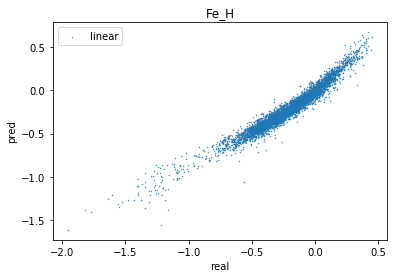

In [25]:
i=2
plt.scatter(y.raw[:,i],w.predict(z).raw[:,i],s=0.2,label="linear")
plt.legend()
plt.xlabel("real")
plt.ylabel("pred")
plt.title(considered_parameters[i])

In [ ]:
normed_w = w.val/np.linalg.norm(w.val,axis=1)[:,None]

In [ ]:
vector.get_vars(z.centered,normed_w)

In [ ]:
vector.get_vars(z_occam.cluster_centered,normed_w)

In [ ]:
idx = 0
plt.hist(vector.project(z_occam.cluster_centered,normed_w)[idx],alpha=0.2)
plt.hist(vector.project(z.centered,normed_w)[idx],alpha=0.2)

In [ ]:
i=9
plt.hist(z_occam.cluster_centered[:,i],label="cluster",alpha=0.2,bins=30)
plt.hist(z.centered[:,i],label="regular",alpha=0.2)
plt.legend()

### Investigating individual clusters

In [65]:
clust_idxs =z_occam.registry["NGC 6791"]

In [66]:
z_occam.registry

{'NGC 6811': array([168]),
 'King 2': array([38]),
 'Trumpler 5': array([217, 218, 219, 220, 221, 222, 223]),
 'Berkeley 98': array([27, 28, 29, 30]),
 'Berkeley 31': array([14]),
 'Collinder 220': array([31]),
 'NGC 752': array([199]),
 'NGC 2304': array([92, 93, 94]),
 'NGC 2420': array([ 97,  98,  99, 100, 101, 102, 103, 104, 105, 106, 107]),
 'King 7': array([40, 41, 42, 43]),
 'Berkeley 44': array([17]),
 'Berkeley 53': array([18, 19, 20, 21]),
 'NGC 1798': array([47, 48, 49, 50, 51, 52]),
 'NGC 2204': array([75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86]),
 'FSR 0496': array([35]),
 'NGC 188': array([53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66]),
 'NGC 1245': array([46]),
 'Teutsch 84': array([216]),
 'Berkeley 71': array([25]),
 'NGC 4337': array([122, 123, 124, 125, 126, 127]),
 'NGC 2324': array([95, 96]),
 'Berkeley 33': array([15]),
 'NGC 7789': array([200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212,
        213]),
 'NGC 1193': array([44, 45]),
 '

Text(0.5, 1.0, 'Fe_H')

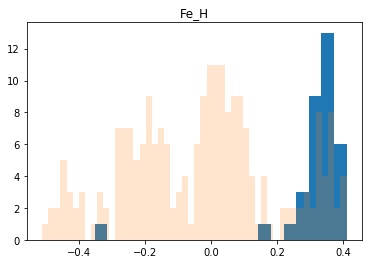

In [80]:
i=2
elem = considered_parameters[i]
plt.hist(z_occam.dataset.allStar[clust_idxs][elem],bins=20)
plt.hist(z_occam.dataset.allStar[elem],bins=50,alpha=0.2)
plt.title(elem)


Text(0.5, 1.0, 'Fe_H')

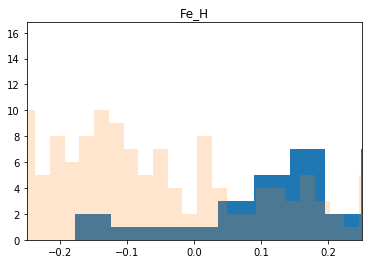

In [81]:
plt.hist(w.predict(z_occam).raw[:,i][clust_idxs],bins=20)
plt.hist(w.predict(z_occam).raw[:,i],bins=50,alpha=0.2)
#plt.hist(vector.project(z_occam.centered,w.val)[i],bins=50,alpha=0.2)

plt.xlim(-0.25,0.25)
plt.title(considered_parameters[i])

Text(0.5, 1.0, 'Fe_H')

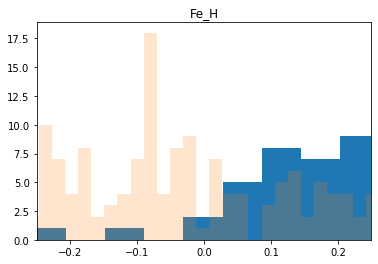

In [82]:
plt.hist(nonlinear_w.predict(z_occam).raw[:,i][clust_idxs],bins=15)
plt.hist(nonlinear_w.predict(z_occam).raw[:,i],bins=50,alpha=0.2)
#plt.hist(vector.project(z_occam.centered,w.val)[i],bins=50,alpha=0.2)
plt.xlim(-0.25,0.25)
plt.title(considered_parameters[i])

(array([ 1.,  0.,  0.,  2.,  0.,  2.,  1.,  5.,  5.,  5.,  7.,  6.,  2.,
         7.,  3.,  3., 10., 16.,  4.,  6.,  4.,  4.,  3., 10.,  5.,  8.,
         6.,  8., 10.,  9.,  7.,  5.,  7.,  4.,  2.,  8.,  4.,  2.,  2.,
         4.,  4.,  3.,  5.,  3.,  2.,  1.,  5.,  0.,  3.,  1.]),
 array([-5.4926753e-01, -5.2729505e-01, -5.0532258e-01, -4.8335007e-01,
        -4.6137759e-01, -4.3940511e-01, -4.1743264e-01, -3.9546013e-01,
        -3.7348765e-01, -3.5151517e-01, -3.2954270e-01, -3.0757019e-01,
        -2.8559771e-01, -2.6362523e-01, -2.4165274e-01, -2.1968026e-01,
        -1.9770777e-01, -1.7573529e-01, -1.5376280e-01, -1.3179033e-01,
        -1.0981784e-01, -8.7845355e-02, -6.5872870e-02, -4.3900385e-02,
        -2.1927901e-02,  4.4584274e-05,  2.2017069e-02,  4.3989554e-02,
         6.5962039e-02,  8.7934524e-02,  1.0990701e-01,  1.3187949e-01,
         1.5385197e-01,  1.7582446e-01,  1.9779694e-01,  2.1976943e-01,
         2.4174191e-01,  2.6371440e-01,  2.8568688e-01,  3.0765936e-

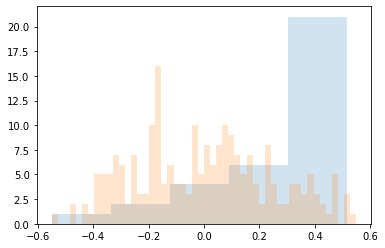

In [83]:
plt.hist(vector.project(z_occam.centered[clust_idxs],w.val)[i],bins=5,alpha=0.2)
plt.hist(vector.project(z_occam.centered,w.val)[i],bins=50,alpha=0.2)

(array([ 1.,  0.,  0.,  2.,  0.,  2.,  1.,  5.,  5.,  5.,  7.,  6.,  2.,
         7.,  3.,  3., 10., 16.,  4.,  6.,  4.,  4.,  3., 10.,  5.,  8.,
         6.,  8., 10.,  9.,  7.,  5.,  7.,  4.,  2.,  8.,  4.,  2.,  2.,
         4.,  4.,  3.,  5.,  3.,  2.,  1.,  5.,  0.,  3.,  1.]),
 array([-5.4926753e-01, -5.2729505e-01, -5.0532258e-01, -4.8335007e-01,
        -4.6137759e-01, -4.3940511e-01, -4.1743264e-01, -3.9546013e-01,
        -3.7348765e-01, -3.5151517e-01, -3.2954270e-01, -3.0757019e-01,
        -2.8559771e-01, -2.6362523e-01, -2.4165274e-01, -2.1968026e-01,
        -1.9770777e-01, -1.7573529e-01, -1.5376280e-01, -1.3179033e-01,
        -1.0981784e-01, -8.7845355e-02, -6.5872870e-02, -4.3900385e-02,
        -2.1927901e-02,  4.4584274e-05,  2.2017069e-02,  4.3989554e-02,
         6.5962039e-02,  8.7934524e-02,  1.0990701e-01,  1.3187949e-01,
         1.5385197e-01,  1.7582446e-01,  1.9779694e-01,  2.1976943e-01,
         2.4174191e-01,  2.6371440e-01,  2.8568688e-01,  3.0765936e-

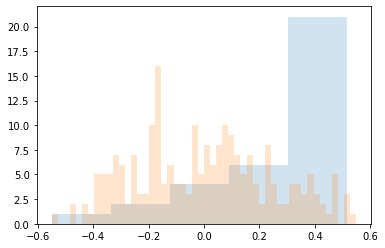

In [84]:
plt.hist(vector.project(z_occam.centered[clust_idxs],w.val)[i],bins=5,alpha=0.2)
plt.hist(vector.project(z_occam.centered,w.val)[i],bins=50,alpha=0.2)

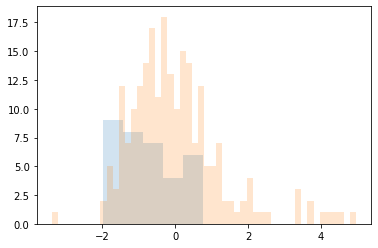

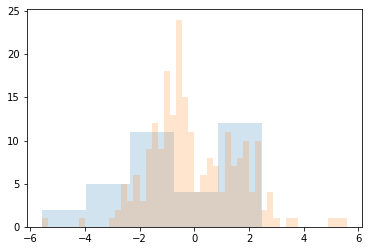

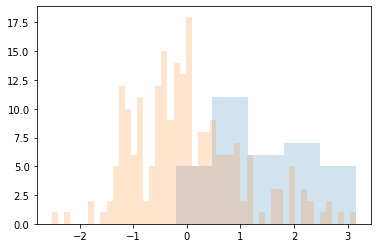

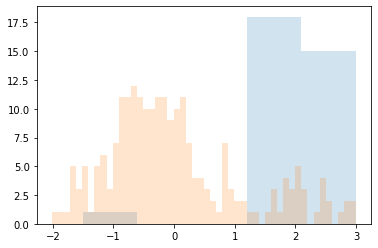

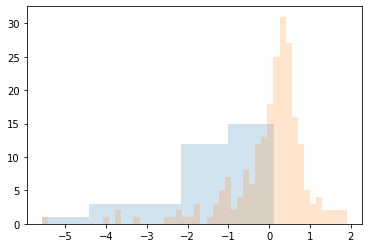

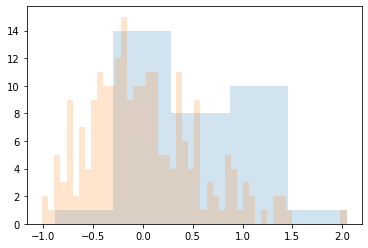

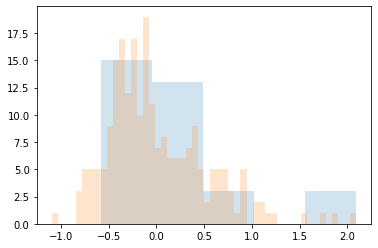

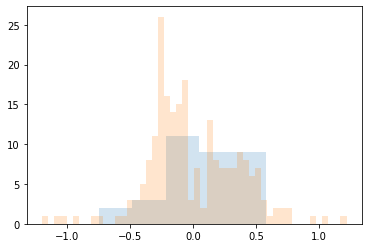

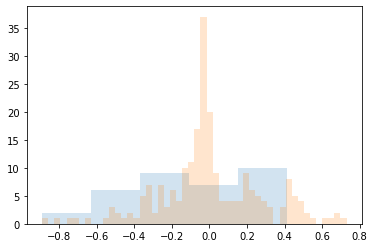

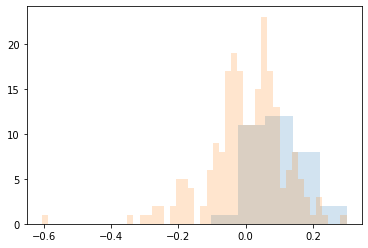

In [85]:
for i in range(10):
    plt.hist(vector.project(z_occam.centered[clust_idxs],cluster_pca.components_)[i],bins=5,alpha=0.2)
    plt.hist(vector.project(z_occam.centered,cluster_pca.components_)[i],bins=50,alpha=0.2)
    plt.show()

In [86]:
cluster_pca.components_

array([[-0.05213233,  0.32141122,  0.06227723, -0.63293123, -0.1349195 ,
         0.6651617 ,  0.09600168,  0.00842565, -0.09848433,  0.0993349 ],
       [ 0.22417057, -0.01773047,  0.20344643,  0.17691214,  0.26388088,
         0.23595749, -0.05509661, -0.8400867 , -0.18014778, -0.10100313],
       [ 0.18387103,  0.10360439,  0.6819665 ,  0.00441362, -0.47659206,
        -0.16292772, -0.14440551, -0.08325095,  0.34760046,  0.29675543],
       [ 0.01136051,  0.02694193, -0.27108508,  0.6366308 , -0.31175548,
         0.5027658 ,  0.23210186,  0.02726535,  0.16853674,  0.29559162],
       [-0.2708403 ,  0.4296162 ,  0.0200465 ,  0.09697464, -0.2425039 ,
        -0.35609877,  0.3482317 , -0.15243179, -0.5976439 ,  0.21207511],
       [ 0.23677833,  0.32068086, -0.49775046, -0.20203176, -0.305327  ,
        -0.25701308,  0.1440574 , -0.34334177,  0.42671508, -0.26930583],
       [-0.2298545 ,  0.03913745,  0.25172034,  0.20467652, -0.36552307,
         0.16793661, -0.01924717,  0.09482676

In [ ]:
vector.project(z_occam.raw,)
#plt.hist(w.predict(z_occam).raw[:,i][clust_idxs],bins=5)
plt.hist(w.predict(z_occam).raw[:,i],bins=50,alpha=0.2)
#plt.xlim(-1,1)
plt.title(considered_parameters[i])

In [ ]:
plt.hist(vector.project(z_occam.centered,normed_w)[i],alpha=0.2)

In [ ]:
plt.hist(z_occam.raw[:,5])

In [ ]:
z_occam.raw[:,0]

In [ ]:
plt.hist(w.predict(z_occam).raw[:,i][clust_idxs],bins=5)
plt.hist(w.predict(z_occam).raw[:,i],bins=50,alpha=0.2)
#plt.xlim(-1,1)
plt.title(considered_parameters[i])